# Quick introduction to Data Augmentor
Small and imbalanced datasets are a big problem. They are suffer from similar challenges such that they may not generalize well, tend to overfit, biased and lacked performance.  
Sometimes augment the dataset can remedy some of the challenges.  
Our implementation of all-in-one DataAugmentor, including our novel implemetation using counterfactuals module can help to tackle those challenges.  
The solution is model and data agnostic (works for all complex models and all kind of datasets).

Below is a small example, how this idea can mitigate limitations of small datasets.   
In this example we will use the `cirrhosis` dataset which is a multiclass classification task.
Cirrhosis dataset is a medical datasets, collected from clinic trials. Its an excellent example due to the fact that it is a small and imbalanced dataset.   
You can see all of our experiments, for different kind of datasets and models in `experimetns/` folder.

## First we will create a basic datascience pipeline

### Initialization
Installing requirements, auto reload changing to code, imports and some configurations

In [14]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd

import sys

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [17]:
# disable tqdm progress bar by default
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Load data

In [18]:
raw_data = pd.read_csv(r"datasets/cirrhosis.csv")
df = utils.preprocess_cirrhosis(raw_data)
target = 'Status'

### split data

In [19]:
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# define continuous_features
continuous_features = X.select_dtypes(include=['number']).columns.tolist()

### Target distribution in train
Can be seen that this is a small and imbalance dataset

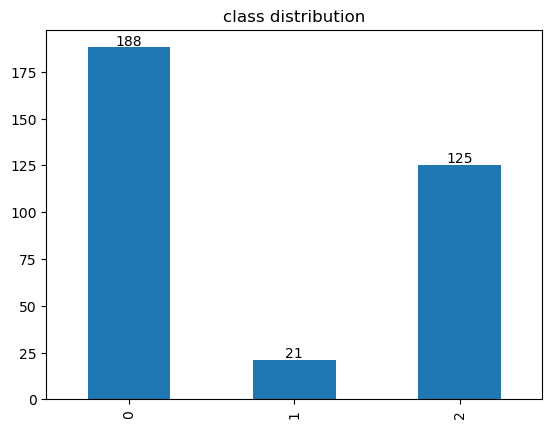

In [21]:
ax = y_train.value_counts().sort_index().plot(kind='bar')
ax.set_title('class distribution')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()-4), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

### Train a model without any augmentation

In [22]:
# define research space to find best model
search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters
metrics = ['f1_weighted', 'accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'] 

best_estimators, best_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                                                      search_estimators=search_pipelines, 
                                                      search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(best_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df.T)

lg        rf       xgb
whole f1_weighted           0.731732  0.773441  0.742029
      accuracy              0.738095  0.797619  0.761905
      balanced_accuracy     0.524411  0.547980  0.528620
      precision_weighted    0.714340  0.776045  0.727952
      recall_weighted       0.738095  0.797619  0.761905
      roc_auc_ovr_weighted  0.871974  0.860169  0.867857
      roc_auc_ovo_weighted  0.839075  0.797379  0.837963

### Augment Data

#### Inflate train
For rare classes, counterfactulas is having trouble to generate many examples. So to remedy this and spped up the proccess, we randomly sample rare class before our augmentation. By deafult we sample up to 50.

In [23]:
X_train_inflate, y_train_inflate = utils.infalte_randomly(X_train, y_train)

### Augmenting
Our DataAugmentor implements several oversampling methods, all model and data agnostics:
* Random over sampling
* SMOTE
* counterfactuals method:
  * Randomized sampling
  * KD-Tree (for counterfactuals within the training data)
  * Genetic algorithm



In this case could take several minutes. Obtaining data is hard and expensive, so how much it several minutes for meaningfull improvment? Please wait, Patience pays :) 

##### define important parameters

In [24]:
method = 'cf_genetic'
kw_args = {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}

In [25]:
# initialize augmentor
if 'cf' in method:
    X_train_for_balance_augmemt, y_train_for_balance_augmemt = X_train_inflate, y_train_inflate
else:
    X_train_for_balance_augmemt, y_train_for_balance_augmemt = X_train, y_train

augmentor = DataAugmentor(X_train_for_balance_augmemt, y_train_for_balance_augmemt, X_test, y_test,
                            method=method, regression=False,
                            continuous_feats=continuous_features,
                            cf_scoring='balanced_accuracy',#f1_weighted
                            kw_args=kw_args
                            )
X_train_augmented, y_train_augmented = augmentor.augment(balance=True)

model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.638047138047138}}
0/63
50/63
0/138
50/138
100/138


### Train model on new augmented data

In [26]:
best_estimators_augmented, best_scores_augmented = utils.fit_and_evaluate(X_train_augmented,
                                                                          y_train_augmented,
                                                                          X_test, y_test,
                                                                          search_estimators=search_pipelines,
                                                                          search_params=search_parameters,
                                                                          scoring=metrics)
result_df_augmented = pd.DataFrame.from_dict(best_scores_augmented, orient='index')
result_df_augmented.columns = pd.MultiIndex.from_product([[f'{method}']] + [result_df_augmented.columns])
display(result_df_augmented.T)

lg        rf       xgb
cf_genetic f1_weighted           0.704654  0.711372  0.747298
           accuracy              0.690476  0.690476  0.750000
           balanced_accuracy     0.644781  0.562290  0.598485
           precision_weighted    0.778307  0.746468  0.745281
           recall_weighted       0.690476  0.690476  0.750000
           roc_auc_ovr_weighted  0.875050  0.852778  0.848313
           roc_auc_ovo_weighted  0.851837  0.815506  0.797198